In [125]:
from tqdm import tqdm
import numpy as np
import torch

from sklearn.datasets import make_moons, make_circles

import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

### Data

In [126]:
N_SAMPLES = 3000
TEST_RATE = 0.2
TEST_IDX_START = int(N_SAMPLES * TEST_RATE)

In [137]:
moons = make_circles(n_samples=N_SAMPLES, noise=0.04, factor=0.4)[0]
X_test, X_train = moons[:TEST_IDX_START], moons[TEST_IDX_START:]

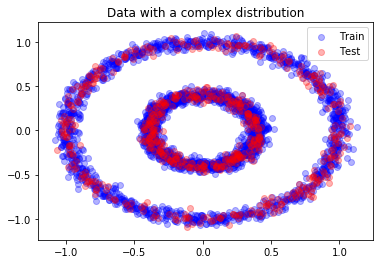

In [138]:
plt.scatter(X_train[:, 0], X_train[:, 1], c='blue', alpha=0.3, label='Train')
plt.scatter(X_test[:, 0], X_test[:, 1], c='red', alpha=0.3, label='Test')
plt.title('Data with a complex distribution')
plt.legend()

In [139]:
class Dataset(torch.utils.data.Dataset):
    
    def __init__(self, X):
        super().__init__()
        self.X = X
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx]
    
def collate_fn(batch):
    return torch.FloatTensor(batch)

In [140]:
train_dataset = Dataset(X_train)
test_dataset = Dataset(X_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, collate_fn=collate_fn)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, collate_fn=collate_fn)

### Normalizing flows

#### Coupling layer:

![Coupling layer](https://lyusungwon.github.io/assets/images/realnvp2.png)

In [141]:
# https://arxiv.org/pdf/1605.08803.pdf - DENSITY ESTIMATION USING REAL NVP
class CouplingLayer(torch.nn.Module):
    """
    
    """
    def __init__(self, data_dim=2, h_dim=32, permutation=0):
        
        super().__init__()
        
        self.data_dim = data_dim
        self.h_dim = h_dim
        self.permutation = permutation
        
        # We initialize inner functions
        self.func_s = torch.nn.Sequential(
            torch.nn.Linear(self.data_dim // 2, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, self.data_dim // 2),
            torch.nn.Tanh()
        )
        self.func_t = torch.nn.Sequential(
            torch.nn.Linear(self.data_dim // 2, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, self.data_dim // 2),
        )
        
    def forward(self, x):
        
        # We separate all elements of vector x into two groups:
        if self.permutation:
            # active is left one
            x_active = x[:, :self.data_dim // 2]
            x_passive = x[:, self.data_dim // 2:]
        else:
            # active is right one
            x_active = x[:, self.data_dim // 2:]
            x_passive = x[:, :self.data_dim // 2]
        
        # Calculate coupling logic:
        z_ = torch.exp(self.func_s(x_passive)) * x_active
        z_ = z_ + self.func_t(x_passive)
        
        z_to_stack = [z_, x_passive] if self.permutation else [x_passive, z_]
        z = torch.cat(z_to_stack, dim=1) 
        
        # Now we need to calculate log determinant of Jacobian of this fucntion below
        # with respect to input x.
        # det(J) = exp(s(x_passive))
        logdet = self.func_s(x_passive).sum(axis=1).mean()
        
        return z, logdet
    
    def inverse(self, z):
        
        # Also separate z as in fovard method for x:
        if self.permutation:
            # active is left one
            z_active = z[:, :self.data_dim // 2]
            z_passive = z[:, self.data_dim // 2:]
        else:
            # active is right one
            z_active = z[:, self.data_dim // 2:]
            z_passive = z[:, :self.data_dim // 2]
            
        # Calculating inversed coupling logic:
        x_ = (z_active - self.func_t(z_passive)) / torch.exp(self.func_s(z_passive))
        x_to_stack = [x_, z_passive] if self.permutation else [z_passive, x_]
        
        x = torch.cat(x_to_stack, dim=1) 
        return x


#### Stack of Coupling layers:

In [142]:
class NormFlowNet(torch.nn.Module):
    """
    
    """
    def __init__(self, n_layers=8, data_dim=2, h_dim=32):
        
        super().__init__()
        
        self.data_dim = data_dim
        self.h_dim = h_dim
        
        self.flows = torch.nn.ModuleList(
            [
                CouplingLayer(self.data_dim, self.h_dim, i % 2) 
                for i in range(n_layers)
            ]
        )
        
        mu = torch.zeros(data_dim)
        sigma = torch.eye(data_dim)
        self.z_prior = torch.distributions.MultivariateNormal(mu, sigma)
        
    def forward(self, x):
        
        # Sequentaly evaluete layer for layer to get z 
        # and also store all logdeterminants
        
        logdet = 0
        flows_x = []
        for flow in self.flows:
            x, logdet_ = flow(x)
            logdet += logdet_
            flows_x.append(x.detach().numpy())
            
        # At the end will calculate p(z) ~ N(mu, sigma)
        log_p = self.z_prior.log_prob(x).mean()
        
        return x, logdet, log_p, flows_x
    
    def inverse(self, z):
        
        for flow in reversed(self.flows):
            z = flow.inverse(z)
        
        return z

#### Train the model:

In [143]:
EPOCHS = 500
LR = 0.0001

In [149]:
net = NormFlowNet(n_layers=8, h_dim=128)
optimizer = torch.optim.Adam(net.parameters(), lr=LR)

In [150]:
pbar = tqdm(range(EPOCHS))
for e in pbar:
    net.train()
    for i, x in enumerate(train_dataloader):
        
        _, logdet, log_p, _ = net(x)
        loss = -(log_p + logdet) 
        
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        
        if i + 1 == len(train_dataloader):
            
            net.eval()
            log_ps, logdets = [], []
            
            for val_x in test_dataloader:
                _, logdet, log_p, _ = net(val_x)
                log_ps.append(log_p.item())
                logdets.append(logdet.item())
                
            val_log_p = np.mean(log_ps)
            val_logdet = np.mean(logdets)
            val_loss = - (val_log_p + val_logdet)
            
            pbar.set_description_str("EPOCH: {:04d}, LOG_P: {:04f}, LOGDET: {:04f}, LOSS: {:04f}"
                .format(e, val_log_p, val_logdet, val_loss))

EPOCH: 0499, LOG_P: -3.047998, LOGDET: 2.272587, LOSS: 0.775412: 100%|██████████| 500/500 [04:16<00:00,  1.95it/s]


#### Sanity checks and validation:

##### test x -> test z

In [158]:
val_x = torch.FloatTensor(test_dataloader.dataset.X)
z, _, _, flows_z = net(val_x)
z = z.detach().numpy()

In [159]:
flows_z.insert(0, test_dataloader.dataset.X)

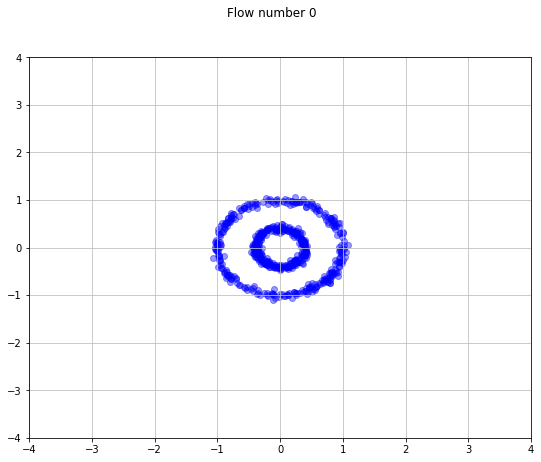

In [160]:
def _update_plot(i, fig, scat):
    fig.suptitle(f'Flow number {i}')
    scat.set_offsets(list([(x[0], x[1]) for x in flows_z[i]]))
    return scat,

fig =  plt.figure(figsize=(9, 7), clear=True)  
ax = fig.add_subplot(111)
ax.grid(True, linestyle='-', color='0.75')
ax.set_xlim([-4, 4])
ax.set_ylim([-4, 4])

scat = plt.scatter(flows_z[0][:, 0], flows_z[0][:, 0], c='blue', alpha=0.4)

anim = animation.FuncAnimation(
    fig, _update_plot, 
    fargs=(fig, scat), 
    frames=len(flows_z), 
    interval=1000
)
HTML(anim.to_jshtml())

##### random_z -> random samples of `x` domain

In [161]:
zs = np.random.normal(size=(500, 2))
zs = torch.FloatTensor(zs)

In [162]:
x_samples = net.inverse(zs).detach().numpy()

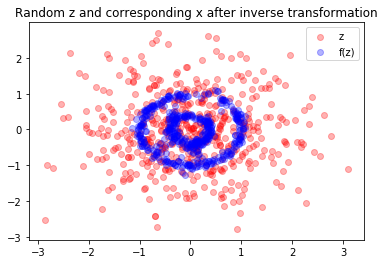

In [163]:
plt.title('Random z and corresponding x after inverse transformation')
plt.scatter(
    zs[:, 0], 
    zs[:, 1], 
    c='red', alpha=0.3, label="z"
)
plt.scatter(
    x_samples[:, 0], 
    x_samples[:, 1], 
    c='blue', alpha=0.3, label="f(z)"
)
plt.legend();